# Lab 07 - Uncertainty Quantification

## Tasks

- Train different machine learning algorithms on noisy data
- Predict the uncertainty from the trained model

## Set up environment

In [1]:
!pip install git+https://github.com/uspas/2021_optimization_and_ml --quiet

In [2]:
!pip install blitz-bayesian-pytorch --quiet

In [3]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import tqdm # For progress bar
#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

#import toy accelerator package
from uspas_ml.accelerator_toy_models import simple_lattices
from uspas_ml.utils import transformer

# Gaussian process
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls import ExactMarginalLogLikelihood

# Neural networks
import torch
import torch.nn as nn
import torch.optim as optim

## Create training data

We start by generating noisy data from a model of beam propagating through a single quad magnet (characterized by a magnetic strength `K1`). In order to simulate fluctuations in beam parameters and noise in the beam size measurement, we add noise in the model.

In [4]:
def xrms_1D(K1, noise=1.5e-3):
    '''
    calculate sigma_x^2
    
    K1 : magnetic strength of single quad magnet, torch.tensor, shape (1,)
    noise : rms noise level of measurement, float
    '''
    #generate initial beam matrix
    # - x/y/z geometric emittance of 1.0e-8 m-rad
    init_beam_matrix = torch.eye(6) * 1.0e-8

    #set x_rms beam size to 1 mm and rms divergence to 0.1 mrad
    init_beam_matrix[0,0] = 1.0e-3 ** 2 
    init_beam_matrix[1,1] = 1.0e-4 ** 2 
    init_beam_matrix[2,2] = 1.0e-3 ** 2 
    init_beam_matrix[3,3] = 1.0e-4 ** 2  
    
    #create accelerator lattice object with one quad and a drift
    line = simple_lattices.create_singlet(K1)
    
    #propagate beam matrix
    final_beam_matrix = line.propagate_beam_matrix(init_beam_matrix, noise)
    return final_beam_matrix[0,0].reshape(1,1).detach()

In [5]:
# Generate 400 samples for K1 varying between -300 and 300
n_samples = 400
bounds = torch.tensor([-300.0, 300.0])
train_x = torch.rand(n_samples) * (bounds[1] - bounds[0]) + bounds[0]
train_x = train_x.reshape(-1,1)
train_y = torch.cat([xrms_1D(K) for K in train_x]).detach()

# Normalize the generated data (scale input between 0 and 1 ; set output to have std of 1)
transformer_x = transformer.Transformer(bounds.reshape(2,1), transform_type = 'normalize')
normed_train_x = transformer_x.forward(train_x)

transformer_y = transformer.Transformer(train_y, transform_type = 'standardize')
normed_train_y = transformer_y.forward(train_y)

Text(0, 0.5, 'Normalized beam size')

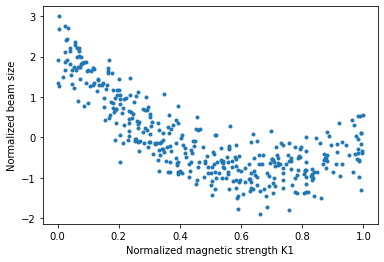

In [6]:
plt.plot( normed_train_x, normed_train_y, '.' )
plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

# Gaussian process

Here we fit a Gaussian process to the data, we draw a few samples from the GP and plot them, along with the uncertainty.

In [7]:
# Define a Gaussian Process model with Matern(5/2) kernel and Gaussian likelihood
gp = SingleTaskGP(normed_train_x, normed_train_y)

# Train model hyperparameters by minimizing negative-Log-Marginal-Likelihood
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_model(mll);

/home/vagrant/.pyenv/versions/py3/lib/python3.7/site-packages/gpytorch/utils/cholesky.py:83: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Text(0, 0.5, 'Normalized beam size')

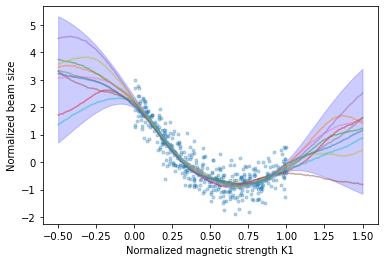

In [8]:
# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Draw samples of the GP, and plot them over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)
p = gp.posterior(x, observation_noise=False )

for _ in range(10):
    sample, = p.rsample()
    plt.plot( x.flatten(), sample.detach().numpy().flatten(), alpha=0.5 )

# Plot the analytical uncertainty
m = p.mean
l,u = p.mvn.confidence_region()
plt.fill_between( x.flatten(), l.detach().numpy(), u.detach().numpy(), color='b', alpha=0.2)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

<div class="alert alert-block alert-info">
    
**Task:** 
    Does the uncertainty behave as expected? In which way? Does the predicted uncertainty 
    capture the aleatoric part or only the epistemic part? If it does not capture the aleatoric part, 
    modify the above code that generates samples from the Gaussian Process, in such a way that it 
    does capture it. 
</div>

**Your answer here** (Does the uncertainty behave as expected? In which way? Does the predicted uncertainty 
    capture the aleatoric part or only the epistemic part?)

In [9]:
# BEGIN SOLUTION
"""
The uncertainty behaves as expected, in that it is low in the area of input space where many training points 
are available (between 0 and 1) and grows outside of this area. The typical distance over which the uncertainty 
grows is consistent with the typical length scale of the function. 
This does not capture the aleatoric part: in the area between 0 and 1, the uncertainty is much smaller than
the typical noise on the beam size. Thus the plotted uncertainty represents the uncertainty on the *average*
beam size, i.e. with the random noise removed.
"""
# END SOLUTION

'\nThe uncertainty behaves as expected, in that it is low in the area of input space where many training points \nare available (between 0 and 1) and grows outside of this area. The typical distance over which the uncertainty \ngrows is consistent with the typical length scale of the function. \nThis does not capture the aleatoric part: in the area between 0 and 1, the uncertainty is much smaller than\nthe typical noise on the beam size. Thus the plotted uncertainty represents the uncertainty on the *average*\nbeam size, i.e. with the random noise removed.\n'

Text(0, 0.5, 'Normalized beam size')

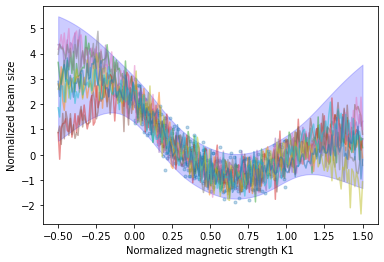

In [10]:
# Your code here: copy the above cell and modify it so as to capture the aleatoric part of the uncertainty

# BEGIN SOLUTION

# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Draw samples of the GP, and plot them over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)
p = gp.posterior(x, observation_noise=True )

for _ in range(10):
    sample, = p.rsample()
    plt.plot( x.flatten(), sample.detach().numpy().flatten(), alpha=0.5 )

# Plot the analytical uncertainty
m = p.mean
l,u = p.mvn.confidence_region()
plt.fill_between( x.flatten(), l.detach().numpy(), u.detach().numpy(), color='b', alpha=0.2)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

# END SOLUTION

# Ensemble of neural networks

We will now train an **ensemble** of neural networks on the same data.

In [11]:
class NNModel(nn.Module):
    """
    Define fully-connected neural network with 2 hidden layers
    """
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(), 
            nn.Linear(10, 10),
            nn.ReLU(), 
            nn.Linear(10, 1),
        )

    def forward(self, x_train):
        x = self.layer(x_train)
        return x

In [12]:
def generate_and_train_model( epochs=100, plot_loss=True ):
    """
    Train a neural network, optionally plot the loss during training 
    (to check convergence), and return the corresponding neural network object
    """
    model = NNModel()
    
    optimizer = optim.Adam(model.parameters(), lr=2e-2)
    
    loss_list = []
    for epoch in tqdm.tqdm(range(epochs)):
        output = model(normed_train_x)
        loss = nn.MSELoss()(output, normed_train_y)
        loss_list.append( float(loss) )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if plot_loss:
        plt.plot( loss_list )
        plt.xlabel( 'Epoch' )
        plt.ylabel( 'Training Loss' )
    
    return model

100%|██████████| 100/100 [00:01<00:00, 55.32it/s]


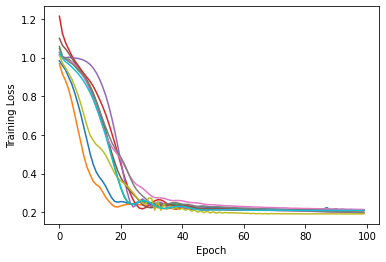

In [13]:
# Train 10 different neural network on the same data
ensemble_models = [ generate_and_train_model() for _ in range(10) ]

In [14]:
def plot_samples_with_mean_plusminus_std(x, y_samples, show_samples=True):
    """
    Helper function that plots samples, along with the mean +/- std
    
    x: numpy array of size (n,)
        points on the horizontal axis
        
    y_samples: list of numpy arrays of size (n,)
        the corresponding samples 

    show_samples: bool
        whether to show the samples or only the mean and std
    """
    # Plot samples
    if show_samples:
        for i in range(len(y_samples)):
            plt.plot(x, y_samples[i], alpha=0.5)
    
    # Calculate mean and std
    y = np.array(y_samples)
    mean = np.mean(y,axis=0)
    std = np.std(y,axis=0)
    plt.plot( x, mean, 'b' )
    plt.fill_between( x, mean-std, mean+std, color='b', alpha=0.2)

<div class="alert alert-block alert-info">
    
**Task:** 
    Modify the code below to plot sample predictions from the ensemble of neural network, and to plot the mean and uncertainty. 
    Since each neural network has been trained on the same dataset, why do they 
    give different predictions? Does the resulting uncertainty capture the aleatoric part?
</div>

Text(0, 0.5, 'Normalized beam size')

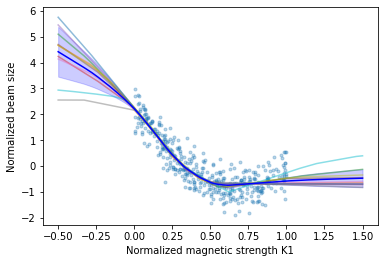

In [15]:
# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Plot predictions of the neural networks over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)

y_samples = []
for model in ensemble_models:
    # Your code here: capture the prediction of each neural network
    
    # BEGIN SOLUTION
    y_samples.append( model(x).detach().numpy().flatten() )
    # END SOLUTION
    
plot_samples_with_mean_plusminus_std(x.flatten(), y_samples, show_samples=True)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

**Your answer here:** (Since each neural network has been trained on the same dataset, why do they 
    give different predictions? Does the resulting uncertainty capture the aleatoric part?)

In [16]:
# BEGIN SOLUTION
"""
The initial value of the weights of the neural networks are initialized randomly. Therefore they 
are different for each of the neural networks in the ensemble. The initial weights influence the 
subsequent training, and thus the trained neural networks in the ensemble do differ.

Ensembles of neural networks only predict the epistemic part of the uncertainty: we can see
that the uncertainty is much lower than the noise, in the area of the input space where 
we have a lot of data.
"""
# END SOLUTION

'\nThe initial value of the weights of the neural networks are initialized randomly. Therefore they \nare different for each of the neural networks in the ensemble. The initial weights influence the \nsubsequent training, and thus the trained neural networks in the ensemble do differ.\n\nEnsembles of neural networks only predict the epistemic part of the uncertainty: we can see\nthat the uncertainty is much lower than the noise, in the area of the input space where \nwe have a lot of data.\n'

# Monte-Carlo Dropout

We now use a Monte-Carlo drop-out neural network to try to assess the uncertainty.

In [17]:
class MCDropoutModel(nn.Module):

    def __init__(self, p):
        """
        Initialize a Monte-Carlo drop-out neural network
        
        p: float
            Drop-out probability
        """
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(1, 10),
            nn.ReLU(),
            nn.Dropout(p), # Set activations to 0 with probability p
            nn.Linear(10, 10),
            nn.ReLU(), 
            nn.Dropout(p), # Set activations to 0 with probability p
            nn.Linear(10, 10),
            nn.ReLU(), 
            nn.Dropout(p), # Set activations to 0 with probability p        
            nn.Linear(10, 1),
        )

    def forward(self, x_train):
        x = self.layer(x_train)
        return x

In [18]:
def generate_and_train_dropout_model( p=0.1, epochs=100, plot_loss=True ):
    """
    Train an MC drop-out neural network, optionally plot the loss during training 
    (to check convergence), and return the corresponding neural network object
    """
    model = MCDropoutModel(p)
    
    optimizer = optim.Adam(model.parameters(), lr=2e-2)
    
    loss_list = []
    for epoch in tqdm.tqdm(range(epochs)):    
        output = model(normed_train_x)
        loss = nn.MSELoss()(output, normed_train_y)
        loss_list.append( float(loss) )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if plot_loss:
        plt.plot( loss_list )
        plt.xlabel( 'Epoch' )
        plt.ylabel( 'Training loss' )
    
    return model

100%|██████████| 200/200 [00:05<00:00, 37.81it/s]


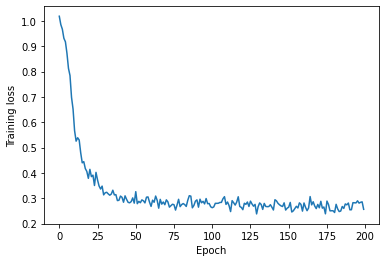

In [19]:
# Train the neural network in the presence of Drop-out
mcdropout_model = generate_and_train_dropout_model(epochs=200)

In [20]:
# Execute this cell several times. 
# The result changes everytime, because different activation neurons are set to 0 (with probability p).
# This gives the uncertainty on the prediction.
mcdropout_model( torch.tensor([[0.3]]) )

tensor([[-0.0230]], grad_fn=<AddmmBackward>)

<div class="alert alert-block alert-info">
    
**Task:** 
    By modifying the code below, generate 10 different sample predictions with the MC dropout model, and plot the corresponding uncertainty.
    
</div>

Text(0, 0.5, 'Normalized beam size')

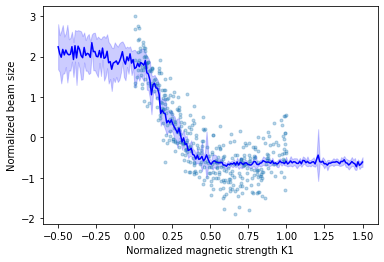

In [21]:
# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Plot predictions of the neural networks over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)

y_samples = []
# Your code here: Collect 10 different sample predictions

# BEGIN SOLUTION
for _ in range(10):
    y_samples.append( mcdropout_model(x).detach().numpy().flatten() )
# END SOLUTION

plot_samples_with_mean_plusminus_std(x.flatten(), y_samples, show_samples=False)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

<div class="alert alert-block alert-info">
    
**Task:** 
    Execute the cell below, and try to plot again the uncertainty. 
    (e.g. by copying the above cell and executing it) What happens and why?
    
</div>

In [22]:
mcdropout_model.eval(); # Set in evaluation mode (this can be reverted by doing `mcdropout_model.train()`)

**Your answer here:** (What happens and why?)

In [23]:
# BEGIN SOLUTION
"""
In evaluation mode, the dropout layers do not randomly set *some* neurons' activate to 0, but it instead scales *all* neurons' activation by (1-p).
Therefore, evaluating the network several times does not produce different results. 
We cannot evaluate the uncertainty by taking the standard deviations of several evaluations.
"""
# END SOLUTION

"\nIn evaluation mode, the dropout layers do not randomly set *some* neurons' activate to 0, but it instead scales *all* neurons' activation by (1-p).\nTherefore, evaluating the network several times does not produce different results. \nWe cannot evaluate the uncertainty by taking the standard deviations of several evaluations.\n"

## Quantile regression

We will now evaluate the uncertainty using quantile regression.

In quantile regression, we instantiate a regular neural network, but train it with specific loss function (see the slides) instead of the usual Mean Squared Error loss function.

<div class="alert alert-block alert-info">
    
**Task:** 
    Implement the quantile regression loss function in the cell below, and execute the 
    following cells to fit quantile regression models to the data.
    
</div>

In [24]:
def quantile_loss_function(y_pred, y_true, quantile):
    """
    Return the loss function for quantile regression
    
    y_pred: array of shape (n,1)
        predictions of the machine learning model
         
    y_true: array of shape (n,1)
        data labels
        
    quantile: float
        (number between 0 and 1)
    """
    # Your code below: modify the lines below to defined the quantile loss function
    # (The current code implements the MSE loss function instead.)
    
    error = y_true - y_pred
    loss = torch.mean( error**2, axis=0 )

    # BEGIN SOLUTION
    loss = torch.mean( torch.max( quantile*error, (quantile-1)*error ), axis=0 )
    # END SOLUTION
    
    return loss

In [25]:
def generate_and_train_quantile_model( quantile, epochs=100, plot_loss=True ):
    """
    Train an quantile neural network, optionally plot the loss during training 
    (to check convergence), and return the corresponding neural network object
    
    quantile: float
        (number between 0 and 1)
    """
    model = NNModel()
    
    optimizer = optim.Adam(model.parameters(), lr=2e-2)
    
    loss_list = []
    for epoch in tqdm.tqdm(range(epochs)): 
        output = model(normed_train_x)
        loss = quantile_loss_function(output, normed_train_y, quantile=quantile)
        loss_list.append( float(loss) )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if plot_loss:
        plt.plot( loss_list )
        plt.xlabel( 'Epoch' )
        plt.ylabel( 'Training loss' )    
        
    return model

100%|██████████| 200/200 [00:04<00:00, 48.88it/s]


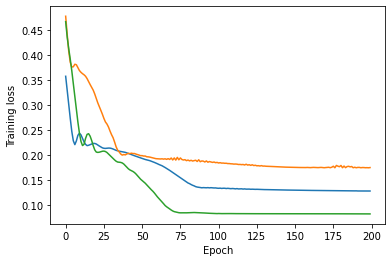

In [26]:
# Pick a few quantile values, and train a neural networks for each of them
quantiles = [0.2, 0.5, 0.9]
quantile_models = [ generate_and_train_quantile_model(q, epochs=200) for q in quantiles ]

Text(0, 0.5, 'Normalized beam size')

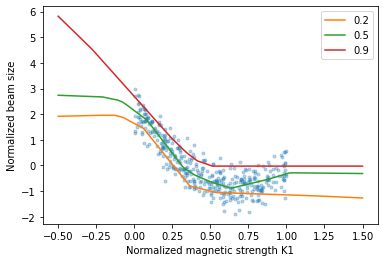

In [27]:
# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Plot predictions of the neural networks over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)

for model, q in zip(quantile_models, quantiles):
    plt.plot( x, model(x).detach().numpy(), label=q )
plt.legend(loc=0)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')

<div class="alert alert-block alert-info">
    
**Task:** 
    Are the relative positions of the 0.2, 0.5 and 0.9 curves as expected? 
    Does this capture the aleatoric part of the uncertainty?
</div>

In [28]:
# BEGIN SOLUTION
"""
The 0.9 is expected to be above the 0.5 curve, which is exptected to be above 0.2 (by definition of the quantiles). This is satisfied by the above plot.
Quantile regression does capture the aleatoric part (e.g. the distance between the 0.9 and 0.2 curve corresponds roughly to the amplitude of the noise.)
"""
# END SOLUTION

'\nThe 0.9 is expected to be above the 0.5 curve, which is exptected to be above 0.2 (by definition of the quantiles). This is satisfied by the above plot.\nQuantile regression does capture the aleatoric part (e.g. the distance between the 0.9 and 0.2 curve corresponds roughly to the amplitude of the noise.)\n'

## Bayesian neural networks

We will now use the `blitz` package to train bayesian neural networks. `blitz` combines with standard `pytorch` neural network models.

In [29]:
# Bayesian neural network
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

In [30]:
# Define a bayesian neural network with two hidden layers (with 10 neurons each) 

# - We use `BayesianLinear` instead of `Linear`. 
#     `BayesianLinear` holds `mu` and `rho` (for each neuron) as trainable parameter, instead of the weights directly.
#     Its output is random, as it draws random weights for each evaluation
# - `variational_estimator` enables additional methods for the class, including the ELBO loss function

@variational_estimator
class BayesianModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            BayesianLinear(1, 10, prior_sigma_1=1., prior_sigma_2=1.e-6, prior_pi=0.5),
            nn.ReLU(),
            BayesianLinear(10, 10, prior_sigma_1=1., prior_sigma_2=1.e-6, prior_pi=0.5),
            nn.ReLU(),        
            BayesianLinear(10, 1, prior_sigma_1=1., prior_sigma_2=1.e-6, prior_pi=0.5),
        )

    def forward(self, x_train):
        x = self.layer(x_train)
        return x

In [31]:
def generate_and_train_bayesian_model( epochs=1000, plot_loss=True ):
    """
    Train a Bayesian neural network, optionally plot the loss during training 
    (to check convergence), and return the corresponding neural network object
    """
    model = BayesianModel()
    
    optimizer = optim.Adam(model.parameters(), lr=2e-2)
    
    loss_list = []
    for epoch in tqdm.tqdm(range(epochs)):
        
        loss = model.sample_elbo(inputs=normed_train_x,
                                 labels=normed_train_y,
                                 criterion=nn.MSELoss(),
                                 sample_nbr=2,
                                 complexity_cost_weight=1./normed_train_x.shape[0])
        loss_list.append( float(loss) )
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if plot_loss:
        plt.plot( loss_list )
        plt.xlabel( 'Epoch' )
        plt.ylabel( 'Training loss' )
    
    return model

100%|██████████| 1000/1000 [00:54<00:00, 18.32it/s]


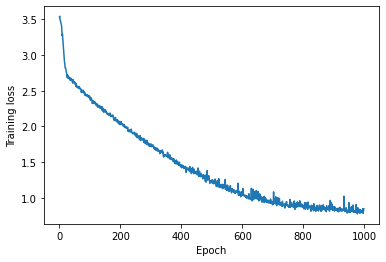

In [32]:
# Train the neural network
bayesian_model = generate_and_train_bayesian_model()

<div class="alert alert-block alert-info">
    
**Task:** 
    By modifying the code below, plot the uncertainty for the Bayesian neural network.
    
</div>

Text(0, 0.5, 'Normalized beam size')

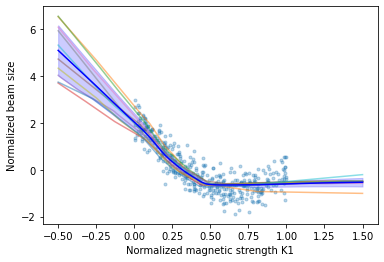

In [33]:
# Plot the original training data
plt.plot( normed_train_x, normed_train_y, '.', alpha=0.3 )

# Plot predictions of the neural networks over the interval -0.5, 1.5
x = torch.linspace(-0.5, 1.5, 200).reshape(-1,1)

y_samples = []
# Your code here: Collect 10 different sample predictions

# BEGIN SOLUTION
for _ in range(10):
    y_samples.append( bayesian_model(x).detach().numpy().flatten() )
# END SOLUTION

plot_samples_with_mean_plusminus_std(x.flatten(), y_samples, show_samples=True)

plt.xlabel('Normalized magnetic strength K1')
plt.ylabel('Normalized beam size')